In [1]:
from scipy.integrate import quad as integrate, trapz 
from scipy import interpolate
from tqdm import tqdm #библиотека индикатора процесса
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("nbagg")   # пакет для анимации 

In [2]:
lq = 3
Num = 100_000 # количество генерируемых точек
hxi = 0.01*np.pi # шаг генерации
beta = 0.0276 # температурный делитель
l = 2*np.pi # область генерации начального распределения
n = int(l/hxi)
 
phix = 0 #-np.pi

# Блок начального распределения состояний
### вычисляем статсумму. не берем интеграл по бесконечному интервалу, потому что функция слишком быстhро стремится к нулю, а встроенные методы пренебрегают пиком в центре интервала

In [3]:
LL = 10*np.pi # интервал, на котором производится интегрирование
X = np.linspace(-LL/2, LL/2, 10_000)

def fun(x): # функция распределения
    return np.exp((np.cos(x)-1)/beta)*np.exp(-((x-phix)**2)/(2*lq*beta))
part_func = trapz(fun(X), X)
# print('Статсумма = ', part_func, 'в математике получили 6.39276*10^-20 при phix = Pi')

In [4]:
def U(x): 
    return (x-phix)**2/(2*lq) + 1 - np.cos(x)

def coor_destr(x):
    return np.exp(-U(x)/beta)/part_func

xi = np.linspace(-np.pi + phix, np.pi + phix, n)
# применяем определение функции распределения
def prob(xx):
    return integrate(lambda phi: coor_destr(phi), -np.inf, xx)[0]

![title](bKMhV5v3mXk.jpg)

<IPython.core.display.Javascript object>


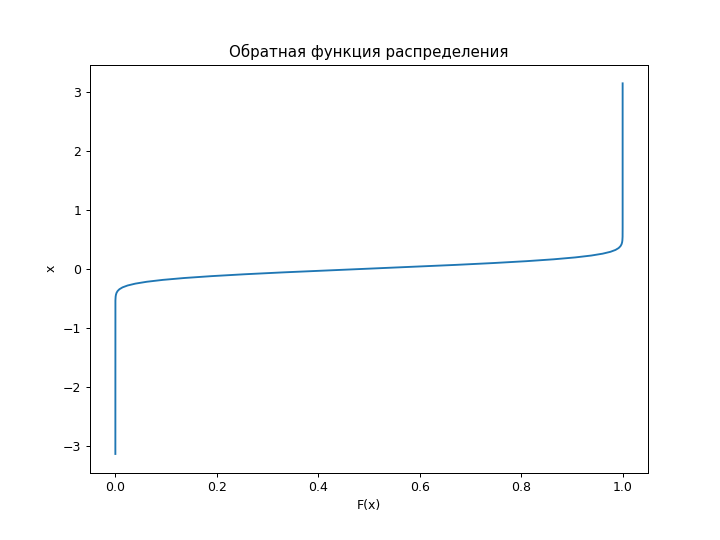

In [5]:
alpha = []
for xx in xi:
    alpha.append(prob(xx))

inter_func = interpolate.interp1d(alpha, xi)
plt.figure(figsize = (8,6))
plt.plot(alpha, inter_func(alpha))
plt.title('Обратная функция распределения')
plt.xlabel('F(x)')
plt.ylabel('x')
plt.show()
# Функция распределения - вероятность того, что случайная величина X примет значение, 
# меньшее или равное х, где х — произвольное действительное число

При устремлении емкости к нулю, мы фактически уменьшаем дисперсию по p (). 


In [6]:
# коэффициент малости
m = 1
k = 1/m

In [14]:
# тут генерируется начальное распределение
# чтобы получить тракторию для одной частицы приравнять
# phi_points = 0, p_points = 0

np.random.seed(1997)
random_points = np.random.random(Num) # Num случайныйх равномерно распределеных чисел [0,1]
phi_points = inter_func(random_points) # значения phi c требуемым распределением
p_points = np.random.normal(0, np.sqrt(m*beta), Num)
 

<IPython.core.display.Javascript object>


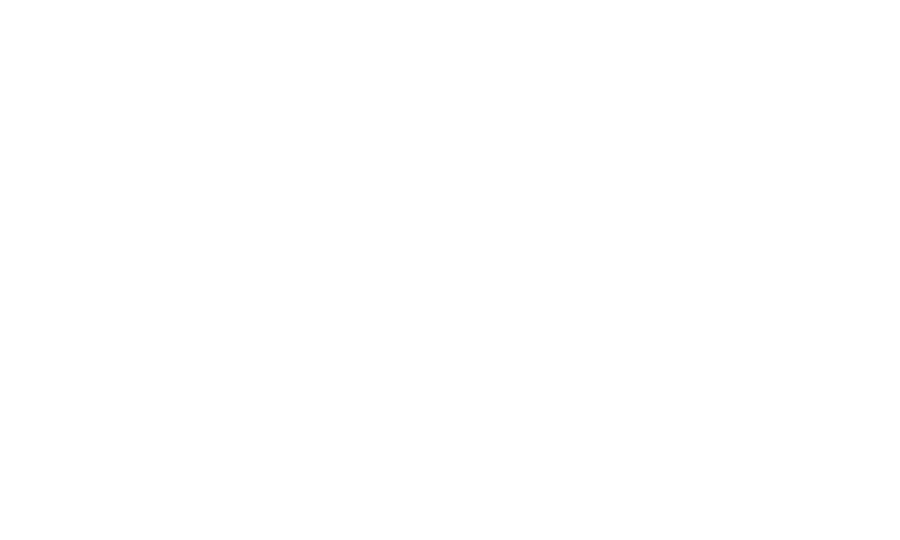

In [15]:
plt.figure(figsize=(10,6))
plt.scatter(phi_points, p_points, s = 0.5) # s - размер точек
plt.xlim(-1.5*np.pi+phix, 1.5*np.pi+phix)
plt.ylim(-np.pi, np.pi)
plt.title('Initial distribution')
plt.ion()   # set interective mode
plt.show()

In [273]:
# тест на количество точек при двухямном потенциале (ожидается одинаковое)
left_points = len(list(filter(lambda x: x < np.pi, phi_points)))
right_points = len(list(filter(lambda x: x > np.pi, phi_points)))
print('В левой яме {} состояний, в правой - {}. Их соотношение: {}'.format(left_points, right_points, right_points/left_points))

В левой яме 100000 состояний, в правой - 0. Их соотношение: 0.0


# Блок динамики во времени

In [10]:
g  = [0.1, 0.05] # коэффициент затухания
tau = 500 # характерное время переключения
T = 500 # полный интервал времени
dt = 0.05 # шаг по времени
t = np.linspace(0,T, int(T/dt))


In [11]:
def phixx(t): # функция именения параметра управления
    return phix + np.pi*(np.tanh(2*np.pi*t/tau - np.pi)+1) 
    
def H(t, phi, p):
    return p**2/2 + (phi-phixx(t))**2/(2*lq) + 1 - np.cos(phi)

def F(t, phi, p):
    return k*p, -np.sin(phi) - (phi - phix - np.pi*(np.tanh(2*np.pi*t/tau - np.pi)+1))/lq - gamma*p

## С трением

In [16]:
# перед запуском задать список g (пусть и единичное значение)

pp = [] # тут хранятся линии для построения
for gamma in g:
    np.random.seed(1997)
    random_points = np.random.random(Num) # Num случайныйх равномерно распределеных чисел [0,1]
    phi_points = inter_func(random_points) # значения phi c требуемым распределением
    p_points = np.random.normal(0, np.sqrt(m*beta), Num)
    plot_iter = 0
    phix_list = []
    phi_list = []
    for it in tqdm(t):
        plot_iter += 1
        plt.clf()
        k1 = F(it, phi_points, p_points)
        k2 = F(it+dt/2, phi_points + dt*k1[0]/2, p_points + dt*k1[1]/2)
        k3 = F(it+dt/2, phi_points + dt*k2[0]/2, p_points + dt*k2[1]/2)
        k4 = F(it+dt, phi_points + dt*k3[0], p_points + dt*k3[1])
        phi_points = phi_points + dt*(k1[0]+2*k2[0]+2*k3[0]+k4[0])/6
        p_points = p_points + dt*(k1[1]+2*k2[1]+2*k3[1]+k4[1])/6
        phi_list.append(phi_points.mean())
    
    pp.append(phi_list)

        # раскомментировать для анимации движения точек 
        # на полотне "Initial dictribution"
        
        #if plot_iter%100 == 0:
            # Установка отображаемых интервалов по осям
            #plt.scatter(phi_points, p_points, s = 0.5) # s - размер точек
            #plt.xlim(-1.5*np.pi+phixx(it), 1.5*np.pi+phixx(it))
            #plt.ylim(-np.pi, np.pi)
            #plt.title("Time:{:.1}".format(it))
            #plt.savefig('anim/best_gif{}.png'.format(plot_iter)) # сохраняет картинки для анимации
            #plt.xlabel('φ')
            #plt.ylabel('p')
            #plt.gcf().canvas.draw()

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:37<00:00, 29.66it/s]


<IPython.core.display.Javascript object>


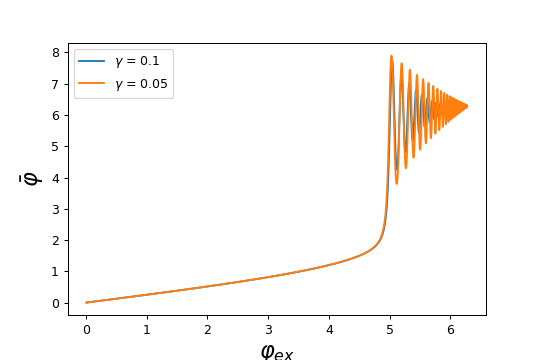

In [42]:
plt.figure(figsize = (6, 4))

for j in range(len(pp)): # построение каждой линии из списка тракторий pp
    plt.plot(phixx(t), pp[-j], label = r"$\gamma$ = {}".format(g[-j])) 
    plt.xlabel(r"$\varphi_{ex}$",fontsize = 18)
    plt.legend()
    plt.ylabel(r"$\bar{\varphi}$",fontsize = 18)
    
plt.show()

## Без трения

In [ ]:
#  обновим начальное распределение, чтобы избежать ошибок

random_points = np.random.random(Num) # Num случайныйх равномерно распределеных чисел [0,1]
phi_points = inter_func(random_points) # значения phi c требуемым распределением
p_points = np.random.normal(0, np.sqrt(m*beta), Num)
plot_iter = 0
gamma = 0
phi_list = []

for it in tqdm(t):
    plot_iter += 1
    plt.clf()
    k1 = F(it, phi_points, p_points)
    k2 = F(it+dt/2, phi_points + dt*k1[0]/2, p_points + dt*k1[1]/2)
    k3 = F(it+dt/2, phi_points + dt*k2[0]/2, p_points + dt*k2[1]/2)
    k4 = F(it+dt, phi_points + dt*k3[0], p_points + dt*k3[1])
    phi_points = phi_points + dt*(k1[0]+2*k2[0]+2*k3[0]+k4[0])/6
    p_points = p_points + dt*(k1[1]+2*k2[1]+2*k3[1]+k4[1])/6
    phi_list.append(phi_points.mean())

 

    #if plot_iter%100 == 0:
        # Установка отображаемых интервалов по осям
        #plt.scatter(phi_points, p_points, s = 0.5) # s - размер точек
        #plt.xlim(-1.5*np.pi+phixx(it), 1.5*np.pi+phixx(it))
        #plt.ylim(-np.pi, np.pi)
        #plt.title("Time:{:.1}".format(it))
        #plt.savefig('anim/best_gif{}.png'.format(plot_iter)) # сохраняет картинки для анимации
        #plt.xlabel('φ')
        #plt.ylabel('p')
        #plt.gcf().canvas.draw()

 42%|████████████████████████████████▏                                            | 4181/10000 [02:06<03:12, 30.29it/s]

In [ ]:
# построение графика
plt.figure(figsize = (6, 4))
plt.ylabel(r"$\bar{\varphi}$", fontsize = 18)
#plt.title(r"$\gamma = {}$".format(gamma))
plt.xlabel(r"$\varphi_{ex}$", fontsize = 18)
plt.plot(phixx(t), phi_list)
plt.show()

<IPython.core.display.Javascript object>


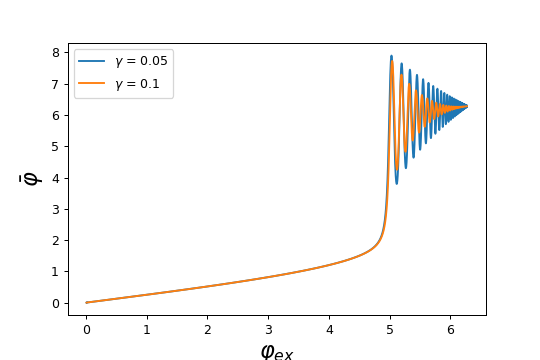

In [311]:
plt.figure(figsize = (6, 4))
plt.plot(phixx(t), pp[1], label = r"$\gamma$ = {}".format(g[1])) 
plt.plot(phixx(t), pp[0], label = r"$\gamma$ = {}".format(g[0])) 
plt.xlabel(r"$\varphi_{ex}$",fontsize = 18)
plt.legend()
plt.ylabel(r"$\bar{\varphi}$",fontsize = 18)
plt.show()